In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

device = torch.device('cuda')

/home/evan/.local/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/evan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        
        # Decoder
        self.dec3 = self.conv_block(256, 128)
        self.dec2 = self.conv_block(128, 64)
        self.dec1 = self.conv_block(64, out_channels)

        self.time_embed = nn.Sequential(
            nn.Linear(1, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
        )

        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
    
    def forward(self, x, t):
        t_emb = self.time_embed(t.unsqueeze(-1)).unsqueeze(-1).unsqueeze(-1)

        # print("hellow")
        # Encode
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        
        # print(e3.dtype, t_emb.dtype)
        e3 = e3 + t_emb

        # Decode
        d3 = self.dec3(F.interpolate(e3, scale_factor=2))
        d2 = self.dec2(F.interpolate(d3 + e2, scale_factor=2))
        d1 = self.dec1(d2 + e1)
        
        return d1    
    

class SimpleDiffusion:
    def __init__(self, num_steps=10):
        self.model = SimpleUNet()
        self.model.to(device)
        self.num_steps = num_steps
        self.beta = torch.linspace(1e-4, 0.02, num_steps, device=device)
        self.alpha = 1 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
    
    def add_noise(self, x, t):
        noise = torch.randn_like(x)
        return (
            torch.sqrt(self.alpha_cumprod[t])[:, None, None, None] * x +
            torch.sqrt(1 - self.alpha_cumprod[t])[:, None, None, None] * noise
        ), noise
    
    def train_step(self, x):
        t = torch.randint(0, self.num_steps, (x.shape[0],), device=device)
        x_noisy, noise = self.add_noise(x, t)
        # print(t)
        # print(x.dtype, t.dtype)
        predicted_noise = self.model(x_noisy, t.float())
        loss = F.mse_loss(noise, predicted_noise)
        return loss

    def generate(self, num_images=1, image_size=(3, 32, 32)):
        device = next(self.model.parameters()).device
        
        # Start from pure noise
        x = torch.randn((num_images, *image_size)).to(device).float()
        
        for t in reversed(range(self.num_steps)):
            t_batch = torch.full((num_images,), t, device=device, dtype=torch.float)
            
            # Predict noise
            predicted_noise = self.model(x, t_batch)
            
            # Compute coefficients
            alpha_t = self.alpha[t]
            alpha_t_bar = self.alpha_cumprod[t]
            
            # Partially denoise the image
            x = (1 / torch.sqrt(alpha_t)) * (
                x - (1 - alpha_t) / torch.sqrt(1 - alpha_t_bar) * predicted_noise
            )
            
            # Add noise if not the last step
            if t > 0:
                noise = torch.randn_like(x)
                sigma_t = torch.sqrt(self.beta[t])
                x += sigma_t * noise
        
        # Ensure pixel values are in [0, 1]
        x = torch.clamp(x, 0, 1)
        return x

# Training loop (pseudo-code)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class_idx = 3

basic_transform = transforms.ToTensor()
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=basic_transform)

target_indices = [i for i, label in enumerate(trainset_full.targets) if label == class_idx]
trainset = Subset(trainset_full, target_indices)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=12, shuffle=True)


print(f'Number of training samples for class cat": {len(trainset)}')
def imshow(img):
    npimg = img.numpy()  # Convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to (H, W, C) for plotting
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
# print(images)

# for i in images:
#     print(i.shape)
#     imshow(i)


Files already downloaded and verified
Number of training samples for class cat": 5000


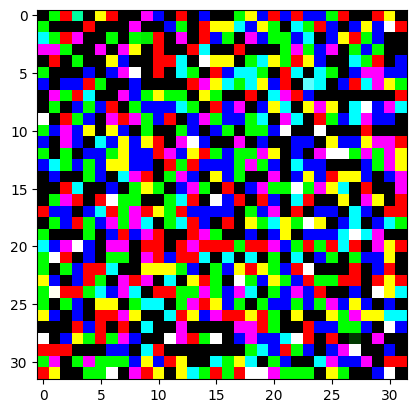

tensor(1.5183, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3671, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3195, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2548, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1733, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1051, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0527, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9844, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9581, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9607, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9314, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9088, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8947, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8862, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9077, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8517, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.8510, device='cuda:0', grad_fn=

In [5]:

diffusion = SimpleDiffusion(num_steps=1000)
# diffusion.model.to(device)
optimizer = torch.optim.Adam(diffusion.model.parameters(), lr=3e-4)

imshow(diffusion.generate().cpu()[0].detach())

num_epochs= 1

for epoch in range(num_epochs):
    for batch, _ in trainloader:
        # print(batch)
        # break
        optimizer.zero_grad()
        loss = diffusion.train_step(batch.to(device))
        print(loss)
        loss.backward()
        optimizer.step()

In [6]:

diffusion.model.train()
for epoch in range(10):
    for batch, _ in trainloader:
        # print(batch)
        # break
        optimizer.zero_grad()
        loss = diffusion.train_step(batch.to(device))
        print(loss)
        loss.backward()
        optimizer.step()

tensor(0.5849, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5673, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5974, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6185, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5840, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5869, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5830, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5749, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5835, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6213, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5832, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5871, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6261, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6034, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.6145, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5905, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.5923, device='cuda:0', grad_fn=

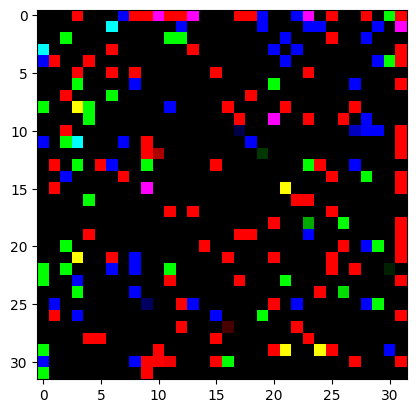

In [7]:
diffusion.model.eval()
imshow(diffusion.generate().cpu()[0].detach())